In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import math
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import L2

In [ ]:

train_dir = 'train'         # has subdirectories 'tumor' and 'normal'
validation_dir = 'validation'

# get image size and batch size
img_height, img_width = 224, 224
batch_size = 16

# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# only rescaling is used for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
# Load the ResNet50 model pre-trained on ImageNet, without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# # freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False


# for layer in base_model.layers[-60:]:
#     layer.trainable = True

# Add a custom classification head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=L2(0.1))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # binary classification

# combine base model with new output layer
model = Model(inputs=base_model.input, outputs=predictions)

In [35]:
# Compile the model with an appropriate learning rate and loss function for binary classification
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (with the base frozen) for initial epochs
initial_epochs = 5

model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / 8), # 8, 16(works better), 32(as good as 8)
    epochs=initial_epochs
)

c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 168s 843ms/step - accuracy: 0.5566 - loss: 0.7895
Epoch 2/5


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


175/175 ━━━━━━━━━━━━━━━━━━━━ 149s 848ms/step - accuracy: 0.6667 - loss: 0.6250
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 149s 846ms/step - accuracy: 0.7693 - loss: 0.5297
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 151s 859ms/step - accuracy: 0.8258 - loss: 0.4407
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 157s 894ms/step - accuracy: 0.8901 - loss: 0.3372


In [36]:
# Fine-tune the model for additional epochs

# Unfreeze the last few layers of the base model for fine-tuning
# for layer in base_model.layers[-1:]:   # here we unfreez & train only the last 10 layers so that we dont overfit 
#     layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
# model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# fine_tune_epochs = 50
# total_epochs = initial_epochs + fine_tune_epochs

# model.fit(
#     train_generator,
#     validation_steps=math.ceil(validation_generator.samples / 8),
#     epochs=total_epochs,
#     initial_epoch=initial_epochs
# )

In [ ]:
# Save the fine-tuned model
model.save('tumor_detection_model7.keras')

# after a lot of fine tuning i found that model 2 has the best results, 86.25% is not something that we would put in practice but given the limited amount of data for
# training our model it is a good performance

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("tumor_detection_model2.keras")
                   
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # normalize pixel values
test_generator = test_datagen.flow_from_directory(
    "validation",
    target_size=(224,224),
    batch_size=16,
    class_mode='binary',  
    shuffle=False  
)

# Predict on test data
y_pred_prob = model.predict(test_generator)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)
print("Predictions completed successfully!")


Found 80 images belonging to 2 classes.


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step
Predictions completed successfully!


Test Accuracy: 86.25%
              precision    recall  f1-score   support

     Healthy       0.94      0.78      0.85        40
        Sick       0.81      0.95      0.87        40

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg       0.87      0.86      0.86        80



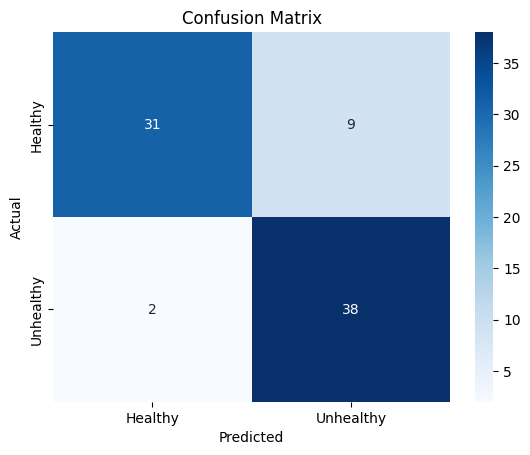

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# True labels (from directory structure)
y_true = test_generator.classes  

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [40]:
"""
here we fit the model 2 times:

1) transfer learning phase: here we train only the new added layers(in our case it was the output layer) so that it can get a feel of the weights &
features of the previous layer. This is good as the weights are good & helps it build a solid foundation, reducing overfitting.

2) fine tuning: here u unfreeze some of the prev weights and fine tune the weights(with a very low learning rate, large LR can destroy the pretrained features)

we use u nets when want an outline. Here we just need to detect the tumor so classification is good enough, but if they want to know the region as 
well then we would need u nets for that

"""

'\nhere we fit the model 2 times:\n\n1) transfer learning phase: here we train only the new added layers(in our case it was the output layer) so that it can get a feel of the weights &\nfeatures of the previous layer. This is good as the weights are good & helps it build a solid foundation, reducing overfitting.\n\n2) fine tuning: here u unfreeze some of the prev weights and fine tune the weights(with a very low learning rate, large LR can destroy the pretrained features)\n\nwe use u nets when want an outline. Here we just need to detect the tumor so classification is good enough, but if they want to know the region as \nwell then we would need u nets for that\n\n'

In [ ]:
# 1) ResNet 50
# model 1: LR = 1e-4, 5 epchos => 0.9362 & 0.9062 train & validation
# model 2: LR = 1e-5, 5 epchos 0.93 & 0.9 train & validation
# model 3: LR = 1e-5, 10 epchos =>  &  train & validation

# 2) 


In [42]:
"""
1. Medical Imaging & Histopathology
U-Net and Variants:

U-Net, U-Net++, Attention U-Net
Use Case: Primarily for segmentation tasks such as tumor delineation, organ segmentation, or identifying regions of interest in histopathology slides.
CNN Architectures:

ResNet, DenseNet, EfficientNet, Inception
Use Case: Classification tasks such as detecting tumors in radiology images (e.g., CT scans, MRIs) or classifying cellular images.
Nuance: Often, these models are fine-tuned on domain-specific data after being pretrained on large datasets like ImageNet.
2. Protein Structure Prediction & Molecular Biology
AlphaFold (AlphaFold2):

Developed by: DeepMind
Use Case: Predicting protein 3D structures with remarkable accuracy—a breakthrough in structural biology.
RoseTTAFold:

Developed by: The Baker Lab
Use Case: Also used for protein structure prediction, providing an alternative approach with competitive performance.
3. Genomics & Transcriptomics
Transformer-based Models:

Examples: DNABERT, Enformer
Use Case: Modeling genomic sequences, predicting gene expression patterns, or interpreting non-coding regions.
Nuance: These models adapt the transformer architecture (originally designed for language tasks) to handle the sequential nature and complexity of DNA/RNA data.
Graph Neural Networks (GNNs):

Use Case: Analyzing biological networks such as gene regulatory networks, protein-protein interaction networks, or cell-cell communication in tissues.
4. Drug Discovery & Chemical Biology
Molecular Transformers:

Use Case: Predicting chemical reactions, molecular properties, or optimizing compounds.
Nuance: These models adapt techniques from NLP to understand and generate chemical structures represented as strings (e.g., SMILES).
DeepChem Models:

Library: DeepChem
Use Case: Provides a suite of deep learning models tailored for predicting molecular properties, virtual screening, and more.
5. Single-Cell Analysis
Variational Autoencoders (VAEs):

Example: scVI (Single-cell Variational Inference)
Use Case: Dimensionality reduction, clustering, and denoising of single-cell RNA-sequencing data.
Graph-based Approaches:

Use Case: Modeling cell-cell interactions and networks, which can be crucial for understanding tissue heterogeneity and disease microenvironments.
Key Considerations When Choosing a Model
Task Specificity:
Understand if your task is classification, segmentation, prediction, or sequence analysis. Each task benefits from different architectures.

Data Availability & Quality:

For imaging tasks, the resolution and annotation quality of images can dictate whether a segmentation model (like U-Net) or a classification CNN (like ResNet) is more appropriate.
For sequence data, the availability of labeled sequences and the inherent noise in biological data are critical.
Computational Resources:
Some state-of-the-art models (e.g., AlphaFold2 or large transformers) are very resource-intensive and may require specialized hardware.

Transfer Learning & Fine-Tuning:
Many models are first pretrained on large, general datasets (e.g., ImageNet for CNNs, or massive protein databases) and then fine-tuned on the specific biological dataset. Deciding how many layers to fine-tune is often empirical and depends on how similar your data is to the pretraining data.

Interpretability & Regulatory Concerns:
Especially in healthcare, model interpretability and compliance with regulatory standards are essential. Sometimes simpler models with transparent decision-making processes are preferred.



"""

'\n1. Medical Imaging & Histopathology\nU-Net and Variants:\n\nU-Net, U-Net++, Attention U-Net\nUse Case: Primarily for segmentation tasks such as tumor delineation, organ segmentation, or identifying regions of interest in histopathology slides.\nCNN Architectures:\n\nResNet, DenseNet, EfficientNet, Inception\nUse Case: Classification tasks such as detecting tumors in radiology images (e.g., CT scans, MRIs) or classifying cellular images.\nNuance: Often, these models are fine-tuned on domain-specific data after being pretrained on large datasets like ImageNet.\n2. Protein Structure Prediction & Molecular Biology\nAlphaFold (AlphaFold2):\n\nDeveloped by: DeepMind\nUse Case: Predicting protein 3D structures with remarkable accuracy—a breakthrough in structural biology.\nRoseTTAFold:\n\nDeveloped by: The Baker Lab\nUse Case: Also used for protein structure prediction, providing an alternative approach with competitive performance.\n3. Genomics & Transcriptomics\nTransformer-based Models: